In [1]:
# Ignore deprecation warnings
from warnings import simplefilter
simplefilter(action="ignore", category=DeprecationWarning)

In [2]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set proper styling
%matplotlib inline
plt.style.use("seaborn")

In [3]:
from sklearn.datasets import load_digits
# Load MNIST dataset
digits = load_digits()

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Normalize data
scaler = MinMaxScaler()
digits.data = scaler.fit_transform(digits.data)
# Split data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, 
                                                    test_size=0.2,
                                                    random_state=0)

In [5]:
def plot_digits(digits, labels=None, 
                resolution=(8, 8), 
                ticks=(3, 3), 
                labels_pred=None, 
                title=None, 
                cmap="binary"):
    """
    Plot grid of given images
    """
    # Define subplots
    fig, axs = plt.subplots(ticks[0], ticks[1], subplot_kw=dict(xticks=[], yticks=[]))
    # Set title if provided
    if title:
        fig.suptitle(title)
    # Check for single axes
    if len(list(axs)) == 1:
        axs = list(axs)
    # Check for multiple axes
    else:
        axs = axs.ravel()
    # Get total ticks
    ticks_total = ticks[0] * ticks[1]
    # Iterate over each tick
    for i in range(ticks_total):
        # Get current axes
        ax = axs[i]
        # Show digit
        ax.imshow(digits[i].reshape(resolution[0], resolution[1]), cmap=cmap)
        # Show labels
        if labels is not None:
            if labels_pred is None:
                color = "black"
            # Compare true and predicted labels
            else:
                # Correctly predicted
                if labels[i] == labels_pred[i]:
                    color = "green"
                # Incorrectly predicted
                else:
                    color = "red"
            ax.text(0.5, 0.5, labels[i], color=color)
    return

Wall time: 1.46 s


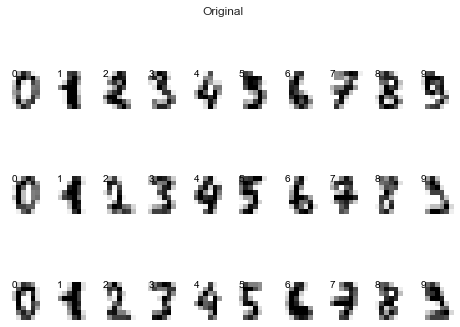

In [6]:
%%time
# Plot original digits
plot_digits(digits.data, labels=digits.target, 
            ticks=(3, 10),
            title="Original")

In [7]:
def plot_pca(pca, X, xlims=None):
    """
    Plot PCA explained variance and explained variance ratio
    """
    # Fit data
    pca.fit(X)
    # Plot parameters
    plt.title("PCA")
    plt.xlabel("number_of_components")
    plt.ylabel("explained_variance_ratio")
    # Cumulative explained variance ratio
    plt.plot(np.cumsum(pca.explained_variance_ratio_), label="explained_variance_ratio")
    # Explained variance
    plt.plot(pca.explained_variance_, label="explained_variance")
    # Check for limits
    if xlims:
        plt.xlim(xlims[0], xlims[1])
    plt.legend(loc="upper left")
    return

Wall time: 1.4 s


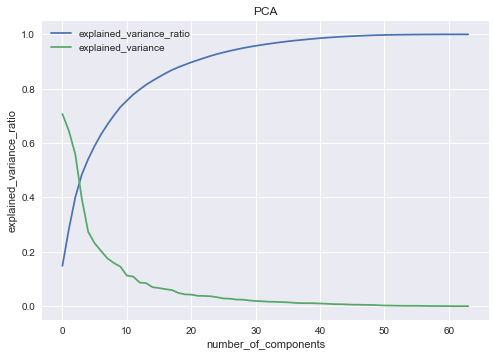

In [8]:
from sklearn.decomposition import PCA
# Pot data PCA variances
%time plot_pca(PCA(random_state=0), digits.data)

In [9]:
from mpl_toolkits.mplot3d import Axes3D
def plot_components(X, y):
    """
    Plot two or three dimensional component relationships
    """
    # Define subplots
    fig, ax = plt.subplots()
    # Get number of dimensions
    dims = X.shape[1]
    # Check for three dimensions
    if dims == 3:
        ax = Axes3D(fig)
    # Plot parameters
    ax.set_title("Reduced Components")
    # Iterate over each label
    for label in np.unique(y):
        # Masked data
        x = X[y == label]
        # Plot depending on dimensions
        if dims == 2:
            plt.scatter(x[:, 0], x[:, 1], label=label)
        elif dims == 3:
            ax.scatter(x[:, 0], x[:, 1], x[:, 2], label=label)    
    plt.legend(loc="best")
    return

Wall time: 292 ms


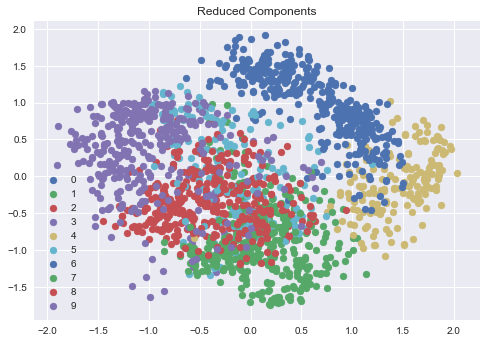

In [10]:
# Plot data two main components
pca = PCA(n_components=2, random_state=0).fit(digits.data)
digits_data_reduced = pca.transform(digits.data)
%time plot_components(digits_data_reduced, digits.target)

Wall time: 124 ms


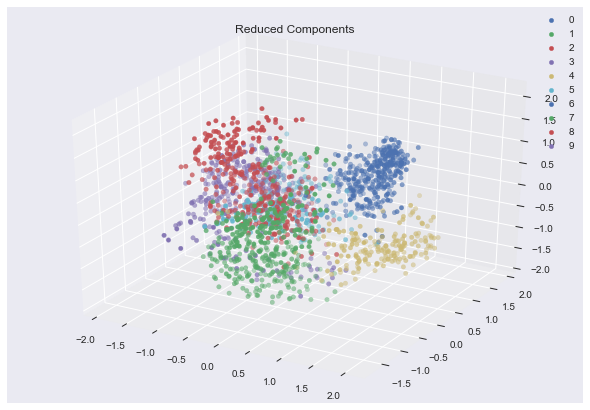

In [11]:
# Plot data three main components
pca = PCA(n_components=3, random_state=0).fit(digits.data)
digits_data_reduced = pca.transform(digits.data)
%time plot_components(digits_data_reduced, digits.target)

Wall time: 652 ms


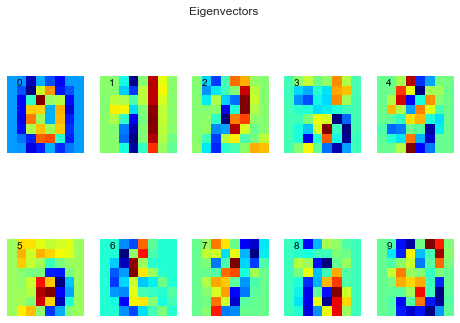

In [12]:
%%time
# Compute eigenvectors for each digit
components = [PCA(n_components=1, random_state=0).fit(digits.data[digits.target == i]).components_ 
              for i in range(10)]
# Plot eigenvectors
plot_digits(components, labels=np.arange(10), ticks=(2, 5), cmap="jet", title="Eigenvectors")

In [13]:
# Reduce data dimensionality
pca = PCA(n_components=0.99, random_state=0).fit(digits.data)
digits_data_reduced = pca.transform(digits.data)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Define grid search parameters
params = {"C": [10, 25, 50, 75, 100], 
          "tol": [0.0001, 0.001, 0.01, 0.1]}
# Define grid search
gs = GridSearchCV(LogisticRegression(penalty="l1", 
                                     solver="saga", 
                                     multi_class="auto", 
                                     max_iter=500, 
                                     random_state=0),
                  params,
                  cv=5,
                  n_jobs=-1,
                  verbose=1)
gs.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=0, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [10, 25, 50, 75, 100],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [15]:
# Define logistic regression with grid search best parameters
log = LogisticRegression(C=10, 
                         tol=0.01, 
                         penalty="l1", 
                         solver="saga", 
                         multi_class="auto", 
                         max_iter=500, 
                         random_state=0)
log.fit(X_train_reduced, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

In [16]:
from sklearn.model_selection import cross_val_score
# Compute model sparsity and score
sparsity = np.mean(log.coef_ == 0) * 100
train_score = cross_val_score(log, X_train_reduced, y_train, cv=5).mean()
test_score = cross_val_score(log, X_test_reduced, y_test, cv=5).mean()
att = {"Sparsity": sparsity, "Train_score": train_score, "Test_score": test_score}

In [17]:
# Show attributes
att

{'Sparsity': 13.18181818181818,
 'Train_score': 0.9708403249031814,
 'Test_score': 0.9325147282657354}

In [18]:
from sklearn.metrics import confusion_matrix
def plot_heatmap(X, y, 
                 clf=LogisticRegression(penalty="l1", 
                                        solver="saga", 
                                        multi_class="auto", 
                                        random_state=0),    
                 labels=digits.target_names):
    """
    Plot heatmap of confusion matrix
    """
    # Predict labels
    y_pred = clf.predict(X)
    # Plot data heatmap
    sns.heatmap(confusion_matrix(y, y_pred).T, 
                square=True, annot=True, fmt='d',
                xticklabels=labels,
                yticklabels=labels)
    # Plot parameters
    plt.xlabel('true_label')
    plt.ylabel('predicted_label')
    plt.ylim(len(labels), 0)
    return

Wall time: 5.14 s


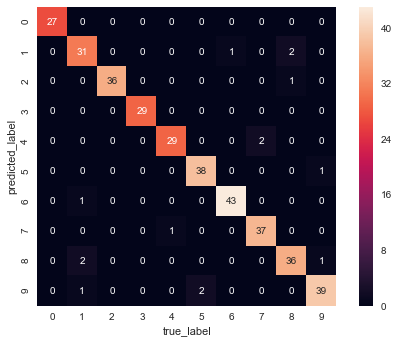

In [19]:
%time plot_heatmap(X_test_reduced, y_test, clf=log)

In [20]:
from sklearn.pipeline import make_pipeline
# Define final model with pipeline
model = make_pipeline(pca, log)
# Calculate final score
final_score = {"final_score": cross_val_score(model, X_test, y_test, cv=5).mean()}

In [29]:
final_score

{'final_score': 0.9324766765153549}

In [30]:
from sklearn.metrics import classification_report
# Make classification report
print("Classification report for classifier %s:\n%s\n"
      %(model, classification_report(y_test, model.predict(X_test))))

Classification report for classifier Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.99,
                     random_state=0, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=0, solver='saga',
                                    tol=0.01, verbose=0, warm_start=False))],
         verbose=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.91      0.89      0.90        35
           2       0.97      1.00      0.99        36
           3     

In [31]:
from sklearn.mixture import GaussianMixture
def bic_aic(X, components=np.arange(1, 25)):
    """
    Plot BIC and AIC gaussian mixture metrics
    """
    # Define models based on number of components
    models = [GaussianMixture(n, covariance_type="full", random_state=0).fit(X) for n in components]
    # Plot parameters
    plt.xlabel("components")
    # Plot curves
    plt.plot(components, [model.bic(X) for model in models], label="BIC")
    plt.plot(components, [model.aic(X) for model in models], label="AIC")
    plt.legend(loc="best")
    return

Wall time: 11.7 s


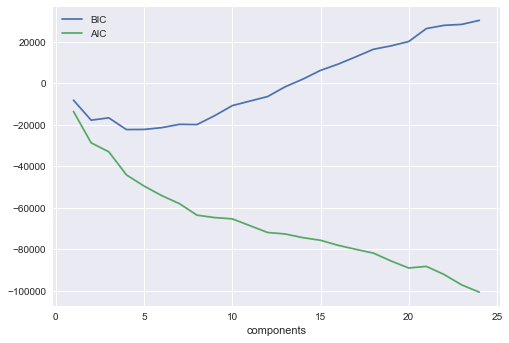

In [32]:
# Plot data BIC and AIC curves
%time bic_aic(X_train_reduced)

In [33]:
def generate_data(X):
    """
    Generate new data from already existing one
    """
    # Reduce data dimensionality
    pca = PCA(n_components=0.99, random_state=0).fit(X)
    X_reduced = pca.transform(X)
    # Define gaussian mixture model with best number of components
    gm = GaussianMixture(250, covariance_type='full', random_state=0, verbose=1).fit(X_reduced)
    # Compute new data with propabilistic gaussian estimations
    new_data, _ = gm.sample(30)
    # Inverse transform new data to match with original dimensions
    new_digits = pca.inverse_transform(new_data)
    return new_digits

Initialization 0
Initialization converged: True
Wall time: 6.58 s


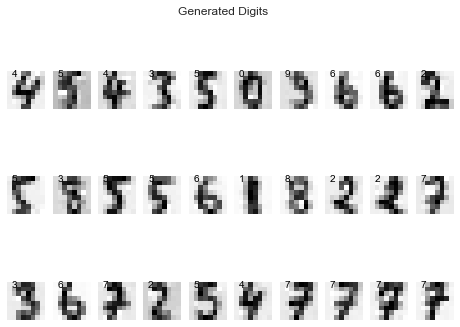

In [34]:
%%time
# Generate new digits
new_digits = generate_data(digits.data)
# Plot new digits and predicted labels
plot_digits(new_digits, labels=model.predict(new_digits),
            resolution=(8, 8),
            ticks=(3, 10),
            title="Generated Digits")

In [35]:
from scipy.stats import mode
# Predict maximum probability
probability = model.predict_proba(new_digits).max(axis=1)
# Lower probability predictions
lower_probability = {"Sample": np.argsort(probability)[:5], "Probability": np.sort(probability)[:5]}

In [36]:
# Show lower probability predictions
lower_probability

{'Sample': array([ 7, 11, 18,  8, 29], dtype=int32),
 'Probability': array([0.77080875, 0.81672388, 0.85033407, 0.9825773 , 0.99354116])}